# Udacity Machine Learning Capstone Project
## Image Classification on the Yelp! Dataset using CNN and Transfer learning
** Part 1: Identifying if the image is 'Inside', 'Outside', 'Food', 'Drink' or a 'Menu' **

In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import glob
from time import time
import os
import cv2
import seaborn as sns
import json
from collections import Counter
import itertools

In [2]:
# Get the paths of photos in the 'photos' folder
image_paths = glob.glob('./photos/*')

In [3]:
# Process 'photos.json' file to extract the required features and labels
photo_id = list()
captions = list()
labels = list()
with open("photos.json") as f_read:
    for line in f_read.readlines():
        jj = json.loads(line)
        captions.append(jj["caption"].encode("utf-8"))
        photo_id.append('photos/' + jj["photo_id"].encode("utf-8")+'.jpg')
        labels.append(jj["label"].encode("utf-8"))

In [4]:
# Print unique labels
in_df = pd.DataFrame({'caption':captions, 'photo_id':photo_id, 'labels':labels})
print "Unique labels present in dataset are:"
set(in_df["labels"])

Unique labels present in dataset are:


{'drink', 'food', 'inside', 'menu', 'outside'}

In [5]:
number_of_labels = Counter(in_df["labels"])
print "Number of labels of 'food' present in the dataset:", number_of_labels['food']
print "Number of labels of 'inside' present in the dataset:", number_of_labels['inside']
print "Number of labels of 'outside' present in the dataset:", number_of_labels['outside']
print "Number of labels of 'drink' present in the dataset:", number_of_labels['drink']
print "Number of labels of 'menu' present in the dataset:", number_of_labels['menu']

Number of labels of 'food' present in the dataset: 132354
Number of labels of 'inside' present in the dataset: 47959
Number of labels of 'outside' present in the dataset: 19122
Number of labels of 'drink' present in the dataset: 6620
Number of labels of 'menu' present in the dataset: 894


The total number of images present in the dataset are nearly 200,000 and thus training all the images can be extremely expensive thus I have chosen to work with only a subset of images and maintaining the class balance. Thus, I will chose 894 labels (since 'menu' has the least number of occurences) for each label and work with 'accuracy' metric.

In [6]:
# Creating a list of 'new_labels' to maintain class balance
new_labels = list()
new_paths = list()
m,n,o,p,q = 0,0,0,0,0
min_freq = min(number_of_labels['food'], number_of_labels['inside'], number_of_labels['outside'], 
               number_of_labels['drink'], number_of_labels['menu'])
for i in range(len(in_df)):
    if(labels[i]=="drink" and m <=min_freq):
        new_labels.append(labels[i])
        new_paths.append(photo_id[i])
        m=m+1
    elif(labels[i]=="food" and n <=min_freq):
        new_labels.append(labels[i])
        new_paths.append(photo_id[i])
        n=n+1
    elif(labels[i]=="inside" and o <=min_freq):
        new_labels.append(labels[i])
        new_paths.append(photo_id[i])
        o=o+1
    elif(labels[i]=="outside" and p <=min_freq):
        new_labels.append(labels[i])
        new_paths.append(photo_id[i])
        p=p+1 
    elif(labels[i]=="menu" and q <=min_freq):
        new_labels.append(labels[i])
        new_paths.append(photo_id[i])
        q=q+1

In [7]:
# One hot encode the labels 
one_hot_labels = list()
for ele in new_labels:
    if(ele=='food'):
        one_hot_labels.append([1.,0,0,0,0])
    elif(ele=='drink'):
        one_hot_labels.append([0,1.,0,0,0])
    elif(ele=='inside'):
        one_hot_labels.append([0,0,1.,0,0])
    elif(ele=='outside'):
        one_hot_labels.append([0,0,0,1.,0])
    elif(ele=='menu'):
        one_hot_labels.append([0,0,0,0,1.])

### Splitting data into Training, Testing and Cross Validation datasets

The dataset is split into training data which comprises of 80% of data, cross validation data into 10% and testing data into 10%

In [8]:
from sklearn.model_selection import train_test_split
x_train_path, x_temp_path, y_train_paths, y_temp_test = train_test_split(new_paths, one_hot_labels,
                                                             stratify=new_labels, train_size=0.8)
x_val_path, x_test_path, y_val_path, y_test_path = train_test_split(x_temp_path, y_temp_test,
                                                                       stratify=y_temp_test, train_size=0.5)

print "Number of training data: ", len(x_train_path)
print "Number of cross validation data: ", len(x_val_path)
print "Number of testing data: ", len(x_test_path)

Number of training data:  3579
Number of cross validation data:  447
Number of testing data:  448


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
from keras.preprocessing import image

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(600, 400))
    # convert PIL.Image.Image type to 3D tensor with shape (600, 400, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 600, 400, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(x_train_path).astype('float32')/255.0
valid_tensors = paths_to_tensor(x_val_path).astype('float32')/255.0
test_tensors = paths_to_tensor(x_test_path).astype('float32')/255.0

## Training Phase

### 1. Simple CNN with 4 hidden layers

In [36]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model_cnn_4 = Sequential()

model_cnn_4.add(Conv2D(filters=16, kernel_size=10, strides=2, padding='valid', activation='relu', 
                       input_shape=(600,400,3)))
model_cnn_4.add(Dropout(0.3))
model_cnn_4.add(MaxPooling2D(pool_size=3))
model_cnn_4.add(Conv2D(filters=32, kernel_size=10, strides=1, padding='same', activation='relu'))
model_cnn_4.add(Dropout(0.3))
model_cnn_4.add(MaxPooling2D(pool_size=3))
model_cnn_4.add(Conv2D(filters=64, kernel_size=10, strides=1, padding='same', activation='relu'))
model_cnn_4.add(Dropout(0.3))
model_cnn_4.add(Conv2D(filters=128, kernel_size=10, strides=1, padding='same', activation='relu'))
model_cnn_4.add(Dropout(0.3))
model_cnn_4.add(MaxPooling2D(pool_size=3))
model_cnn_4.add(Dense(64, activation='relu'))
model_cnn_4.add(Dropout(0.3))
model_cnn_4.add(GlobalAveragePooling2D())
model_cnn_4.add(Dense(5, activation='softmax'))

model_cnn_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 296, 196, 16)      4816      
_________________________________________________________________
dropout_23 (Dropout)         (None, 296, 196, 16)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 98, 65, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 98, 65, 32)        51232     
_________________________________________________________________
dropout_24 (Dropout)         (None, 98, 65, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 21, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 21, 64)        204864    
__________

In [37]:
from keras.callbacks import ModelCheckpoint
from keras import optimizers

# Compile the model, optimizer 'rmsprop', loss 'categorical cross entropy' and metrics 'accuracy'
model_cnn_4.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# 
epochs = 25
checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.env_cnn_4.hdf5', 
                               verbose=1, save_best_only=True)

history_cnn_4 = model_cnn_4.fit(train_tensors, y_train_paths, 
          validation_data=(valid_tensors, y_val_path),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 3579 samples, validate on 447 samples
Epoch 1/25
3579/3579 [==============================] - 29s - loss: 4.3465 - acc: 0.2112 - val_loss: 1.6096 - val_acc: 0.1969
Epoch 2/25
3579/3579 [==============================] - 28s - loss: 1.7259 - acc: 0.2397 - val_loss: 1.5642 - val_acc: 0.2975
Epoch 3/25
3579/3579 [==============================] - 28s - loss: 1.5092 - acc: 0.3666 - val_loss: 1.3840 - val_acc: 0.4899
Epoch 4/25
3579/3579 [==============================] - 28s - loss: 1.4376 - acc: 0.4728 - val_loss: 1.2626 - val_acc: 0.5414
Epoch 5/25
3579/3579 [==============================] - 28s - loss: 1.1749 - acc: 0.5731 - val_loss: 1.0685 - val_acc: 0.5727
Epoch 6/25
3579/3579 [==============================] - 28s - loss: 1.0499 - acc: 0.6153 - val_loss: 1.2557 - val_acc: 0.5168
Epoch 7/25
3579/3579 [==============================] - 29s - loss: 0.9043 - acc: 0.6728 - val_loss: 0.9189 - val_acc: 0.6935
Epoch 8/25
3579/3579 [==============================] - 28s - loss: 0.8

#### Training plots for CNN with 4 hidden layers

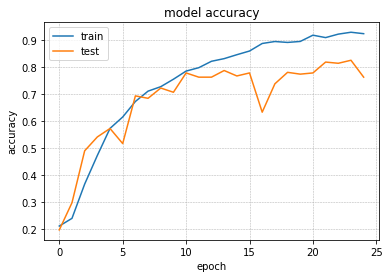

In [52]:
plt.plot(history_cnn_4.history['acc'])
plt.plot(history_cnn_4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

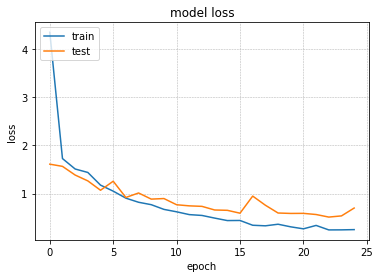

In [54]:
plt.plot(history_cnn_4.history['loss'])
plt.plot(history_cnn_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

#### Test Accuracy on CNN with 4 hidden layers

In [56]:
score_cnn4 = 0
for k,path in enumerate(x_test_path):
    pred_ = np.argmax(model_cnn_4.predict(paths_to_tensor([path]).astype('float32')/255))
    if (pred_==np.argmax(y_test_path[k])):
        score_cnn4=score_cnn4+1
        
print "Testing Accuracy on 4 layer CNN: ", float(score_cnn4)/len(x_test_path)

Testing Accuracy on 4 layer CNN:  0.761160714286


### 2. Transfer Learning: VGG19

In [19]:
from keras.applications import VGG19
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(600,400,3))

#for layer in vgg19_model.layers[:5]:
#    layer.trainable = False
    
x = vgg19_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)
model_vgg19 = Model(inputs=vgg19_model.input, outputs=predictions)
model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 100, 128)     0         
__________

In [21]:
from keras.callbacks import ModelCheckpoint

model_vgg19.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 8

checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.env_vgg19.hdf5', 
                               verbose=1, save_best_only=True)

history_vgg19 = model_vgg19.fit(train_tensors, y_train_paths, 
          validation_data=(valid_tensors, y_val_path),
          epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 3579 samples, validate on 447 samples
Epoch 1/8
3579/3579 [==============================] - 1428s - loss: 0.6028 - acc: 0.7603 - val_loss: 0.3450 - val_acc: 0.8434
Epoch 2/8
3579/3579 [==============================] - 1408s - loss: 0.2203 - acc: 0.9212 - val_loss: 0.2446 - val_acc: 0.8926
Epoch 3/8
3579/3579 [==============================] - 1406s - loss: 0.1142 - acc: 0.9584 - val_loss: 0.2048 - val_acc: 0.9284
Epoch 4/8
3579/3579 [==============================] - 1395s - loss: 0.0656 - acc: 0.9779 - val_loss: 0.3012 - val_acc: 0.9105
Epoch 5/8
3579/3579 [==============================] - 1394s - loss: 0.0348 - acc: 0.9894 - val_loss: 0.2629 - val_acc: 0.9284
Epoch 6/8
3579/3579 [==============================] - 1390s - loss: 0.0237 - acc: 0.9933 - val_loss: 0.2486 - val_acc: 0.9306
Epoch 7/8
3579/3579 [==============================] - 1390s - loss: 0.0226 - acc: 0.9925 - val_loss: 0.3039 - val_acc: 0.9217
Epoch 8/8
3579/3579 [==============================] - 1386s - l

#### Training plots for VGG19

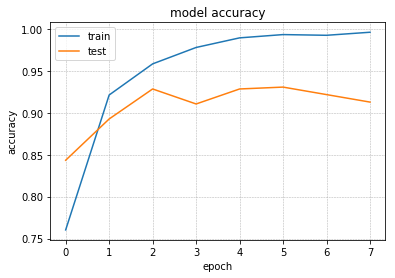

In [22]:
plt.plot(history_vgg19.history['acc'])
plt.plot(history_vgg19.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

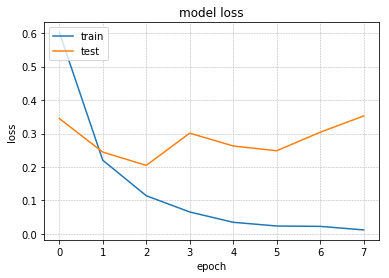

In [23]:
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

#### Testing accuracy of VGG19

In [24]:
score_vgg19 = 0
predictions_vgg19 = list()
false_prediction_vgg19_path = list()
false_prediction_vgg19_pred = list()
false_prediction_vgg19_actual = list()
for k,path in enumerate(x_test_path):
    pred_ = np.argmax(model_vgg19.predict(paths_to_tensor([path]).astype('float32')/255))
    predictions_vgg19.append(pred_)
    if (pred_==np.argmax(y_test_path[k])):
        score_vgg19=score_vgg19+1
    else:
        false_prediction_vgg19_path.append(x_test_path[k])
        false_prediction_vgg19_pred.append(pred_)
        false_prediction_vgg19_actual.append(np.argmax(y_test_path[k]))
        
        
print "Testing Accuracy on VGG19: ", float(score_vgg19)/len(x_test_path)

Testing Accuracy on VGG19:  0.946428571429


### 2. Transfer Learning: ResNet50

In [15]:
from keras.applications import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(600,400,3))

#for layer in vgg19_food.layers[:3]:
#    layer.trainable = False
    
x = resnet_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)
model_resnet50 = Model(inputs=resnet_model.input, outputs=predictions)

model_resnet50.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 600, 400, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 300, 200, 64)  9472        input_2[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 300, 200, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_50 (Activation)       (None, 300, 200, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [17]:
from keras.callbacks import ModelCheckpoint

model_resnet50.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
                           loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 8

checkpointer = ModelCheckpoint(filepath='final_weights/weights.best.env_resnet50.hdf5',
                              verbose=1, save_best_only=True)

history_resnet50 = model_resnet50.fit(train_tensors, y_train_paths,
                              validation_data=(valid_tensors, y_val_path),
                              epochs=epochs, batch_size=10, callbacks=[checkpointer], verbose=1)

Train on 3579 samples, validate on 447 samples
Epoch 1/8
3579/3579 [==============================] - 598s - loss: 0.8331 - acc: 0.6882 - val_loss: 1.5071 - val_acc: 0.4676
Epoch 2/8
3579/3579 [==============================] - 586s - loss: 0.3424 - acc: 0.8807 - val_loss: 0.3876 - val_acc: 0.8456
Epoch 3/8
3579/3579 [==============================] - 586s - loss: 0.2564 - acc: 0.9117 - val_loss: 0.1707 - val_acc: 0.9418
Epoch 4/8
3579/3579 [==============================] - 586s - loss: 0.2143 - acc: 0.9240 - val_loss: 0.1647 - val_acc: 0.9530
Epoch 5/8
3579/3579 [==============================] - 584s - loss: 0.1740 - acc: 0.9402 - val_loss: 0.1748 - val_acc: 0.9508
Epoch 6/8
3579/3579 [==============================] - 586s - loss: 0.1287 - acc: 0.9570 - val_loss: 0.1596 - val_acc: 0.9485
Epoch 7/8
3579/3579 [==============================] - 586s - loss: 0.1104 - acc: 0.9648 - val_loss: 0.1531 - val_acc: 0.9620
Epoch 8/8
3579/3579 [==============================] - 585s - loss: 0.0

#### Test accuracy on ResNet50 architecture

In [18]:
score_resnet = 0
predictions_resnet = list()
false_prediction_resnet_path = list()
false_prediction_resnet_pred = list()
false_prediction_resnet_actual = list()
for k,path in enumerate(x_test_path):
    pred_ = np.argmax(model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255))
    predictions_resnet.append(pred_)
    if (pred_==np.argmax(y_test_path[k])):
        score_resnet=score_resnet+1
    else:
        false_prediction_resnet_path.append(x_test_path[k])
        false_prediction_resnet_pred.append(pred_)
        false_prediction_resnet_actual.append(np.argmax(y_test_path[k]))
        
        
print "Testing Accuracy on ResNet50: ", float(score_resnet)/len(x_test_path)

Testing Accuracy on ResNet50:  0.950892857143


### Performance of CNN architectures

**CNN with 4 layers:** 76.11%

**VGG19:** 94.64%

**ResNet50:** 95.08%

We see that the ResNet 50 architecture has the highest accuracy. And it certainly provides superior performance compared to a simple CNN with 4 layers, which was our benchmark. Thus, I have chosen ResNet50 as my architecture to predict the environment.

#### Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
    
test_labels = list()
for ele in y_test_path:
    test_labels.append(np.argmax(ele))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization


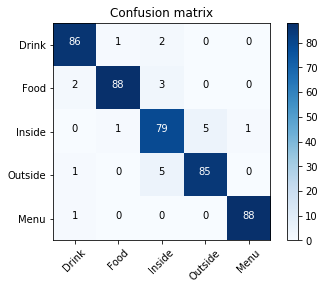

In [27]:
cmf_resnet50 = confusion_matrix(predictions_resnet, test_labels)
plt.figure()
plot_confusion_matrix(cmf_resnet50, classes=['Drink', 'Food', 'Inside', 'Outside', 'Menu'])
plt.show()

We can clearly see that the model makes realtively more mistakes on images with labels pertaining to if the images is that of 'Inside' or 'Outside'. This is natural because more sunlight inside a restaurant may cause the model to make false predictions as being outside. Conversely, when tables and seats are placed outside, the model may mistakenly predict as being 'Inside'. These are some mistakes that a human may also make. 

Also, model mistakenly predict some images of 'Drinks' as food if there is a plate of food next to it. This also a common mistake that a human might make. 

#### Understanding false predictions

In [30]:
def get_label(label):
    if (label==0):
        return 'Food'
    elif (label==1):
        return 'Drink'
    elif (label==2):
        return 'Inside'
    elif (label==3):
        return 'Outside'
    elif (label==4):
        return 'Menu'

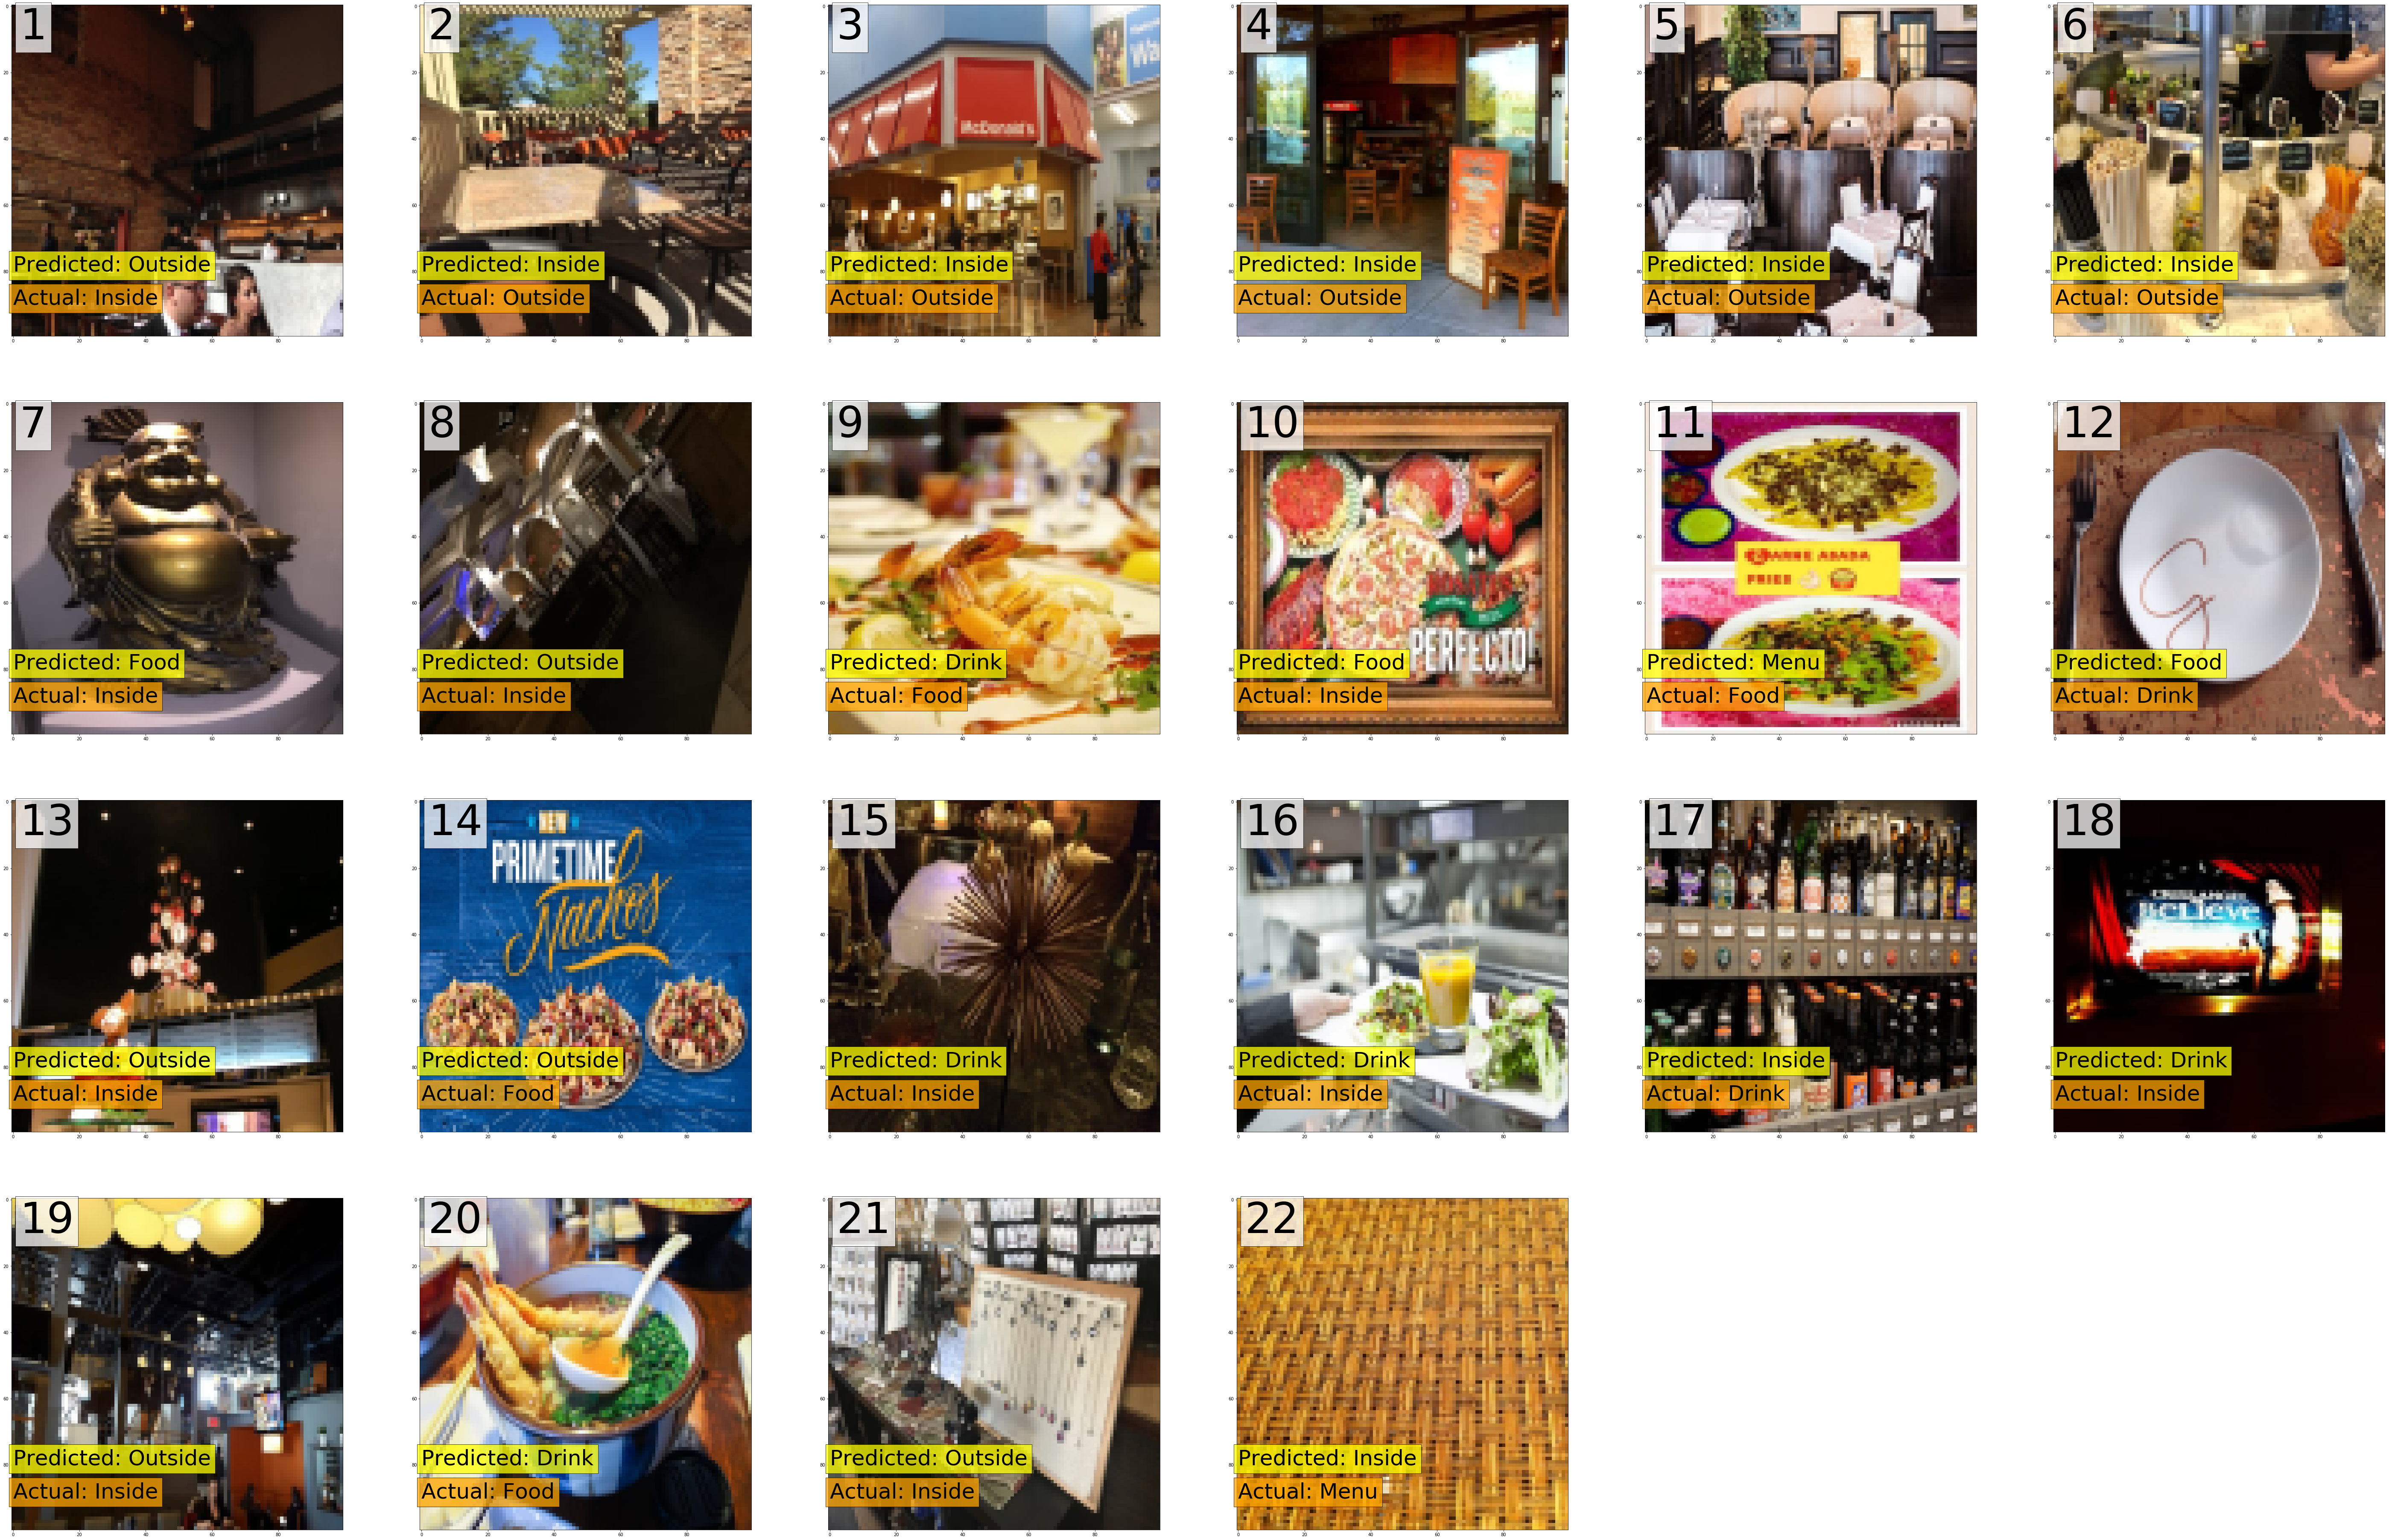

In [31]:
fig=plt.figure(figsize=(100, 100))
columns = 6
rows = 6
for k,path in enumerate(false_prediction_resnet_path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (100,100), interpolation = cv2.INTER_AREA)
    cv_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(rows, columns, k+1)
    ax.text(2, 10, str(k+1), size=100, 
            bbox={'facecolor':'white', 'alpha':0.75, 'pad':10})
    ax.text(0, 80, 'Predicted: '+get_label(false_prediction_resnet_pred[k]), size=50, 
            bbox={'facecolor':'yellow', 'alpha':0.75, 'pad':10})
    ax.text(0, 90, 'Actual: '+get_label(false_prediction_resnet_actual[k]), size=50, 
            bbox={'facecolor':'orange', 'alpha':0.75, 'pad':10})
    plt.imshow(cv_rgb)
plt.show()

It is clear that the model mistaked some labels as 'Inside/Outside' for 'Outside/Inside' labels. This has to do with certain lighting conditions. For example, take image 13, the model predicted as being outside. This is hard even for a human to distinguish between being inside or outside. So was image 8, 1 and 19. In image 14, the model might have mistakened the blue color for sky and may have predicted as being outside. Although image 16 does contain a drink, the actual label was Inside, although our model predicted as being a drink. Image 12 is labelled wrong (I don't see any drink). If the outside is well lit with warm lighting, the model might think it's inside, as seen in image 3.

### Making prediction on other 'Yelp' dataset

In [38]:
# Function to make prediction and display images and labels
def get_prediction(path):    
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, channels = np.shape(cv_rgb)
    plt.imshow(cv_rgb)
    pred_ = np.argmax(model_resnet50.predict(paths_to_tensor([path]).astype('float32')/255))
    in_df = {'Label':['Food', 'Drink', 'Inside', 'Outside', 'Menu']
           ,'Probability':model_resnet50.predict(path_to_tensor(path).astype('float32')/255)[0]}
    plt.text(width+5,height, DataFrame(in_df), size=10)
    plt.text(width*0.3, height*0.9, "Prediction: "+get_label(pred_), 
             bbox={'facecolor':'white', 'alpha':0.75, 'pad':10}, size=15)
    plt.show()

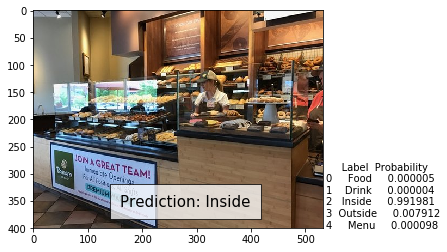

In [41]:
get_prediction('photos/soK1szeyan202jnsGhUDmA.jpg') # Actual label: Inside

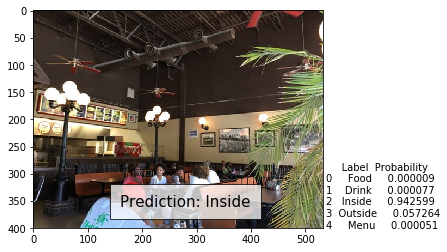

In [42]:
get_prediction('photos/yyK6VcsFWcFCONtAWb_wkg.jpg') # Actual label: Inside

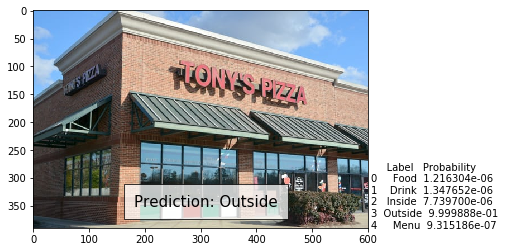

In [44]:
get_prediction('photos/YksxwSt6N0l-m9uTu4igtQ.jpg') # Actual label: Outside

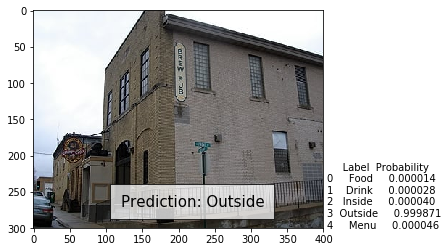

In [45]:
get_prediction('./photos/z8Y6vBLZXoWr0sweDb3vGA.jpg') # Actual label: Outside

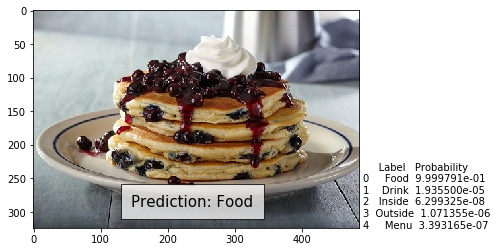

In [46]:
get_prediction('./photos/yhyYN6FdALeGOpN4lfFUWg.jpg') # Actual label: Food

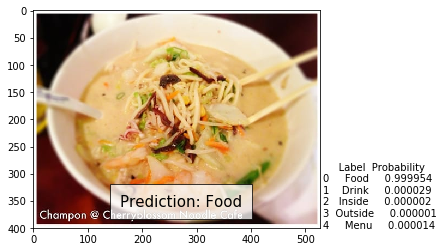

In [48]:
get_prediction('./photos/CmKnDPL0YlaHAnHwSEkkeg.jpg') # Actual label: Food

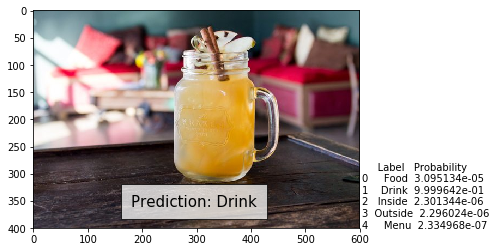

In [50]:
get_prediction('./photos/vANeJAh6q6J4PycSVd0AeA.jpg') # Actual label: Drink

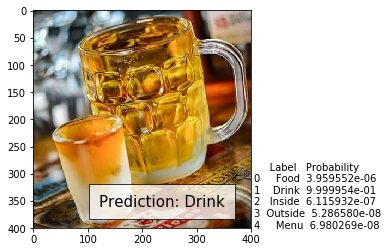

In [51]:
get_prediction('./photos/kAr8r1du9N4bKAK3uNW8Mw.jpg') # Actual label: Drink

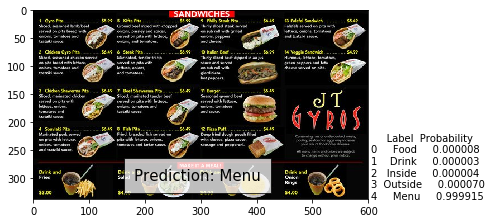

In [52]:
get_prediction('./photos/vg78Q4R77NNlMvhrH-GbjQ.jpg') # Actual lable: Menu

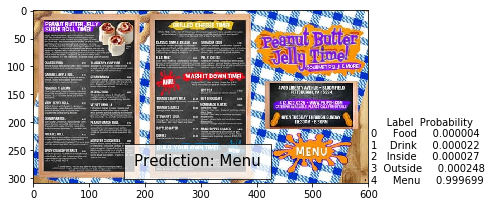

In [53]:
get_prediction('./photos/DBZ6JWYw60OHxASIeQbjTg.jpg') # Actual label: Menu

### Export VGG19 architecture

In [54]:
model_vgg19_yaml = model_resnet50.to_yaml()
with open("final_model/model_env.yaml", "w") as yaml_file:
    yaml_file.write(model_vgg19_yaml)